In [10]:
from SimPEG import *
from simpegAIP.TD import ProblemATEMIP_b, ColeColeTimeMap
from SimPEG import EM
from pymatsolver import MumpsSolver
from scipy.constants import mu_0
from EMTD.Utils import hzAnalyticDipoleT_CC

In [24]:
cs, ncx, ncz, npad = 25., 25, 20, 15
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sighalf = 1e-2
siginf = np.ones(mesh.nC)*1e-8
siginf[mesh.gridCC[:,-1]<0.] = sighalf
eta = np.ones(mesh.nC)*0.2
tau = np.ones(mesh.nC)*0.005
c = np.ones(mesh.nC)*0.7
m = np.r_[siginf, eta, tau, c]
mapping = ColeColeTimeMap(mesh)
prob = ProblemATEMIP_b(mesh, mapping=mapping)
waveformType="STEPOFF"
prob.timeSteps = [(1e-6, 20), (1e-5, 20), (1e-4, 20), (1e-3, 10)]
tobs = np.logspace(-4, -2, 21)
offset = 50.
rx = EM.TDEM.RxTDEM(np.array([[offset, 0., 0.]]), tobs, "bz")
# src = EM.TDEM.SrcTDEM_CircularLoop_MVP([rx], np.array([[0., 0., 0.]]), 13., waveformType)
src = EM.TDEM.SrcTDEM_VMD_MVP([rx], np.array([[0., 0., 0.]]), waveformType=waveformType)
survey = EM.TDEM.SurveyTDEM([src])
prob.Solver = MumpsSolver
prob.pair(survey)

In [25]:
out = survey.dpred(m)

>> Step waveform: Non-zero initial condition


In [26]:
bza = mu_0*hzAnalyticDipoleT_CC(offset, rx.times, sigmaInf=sighalf, eta=eta[0], tau=tau[0], c=c[0])

Populating the interactive namespace from numpy and matplotlib


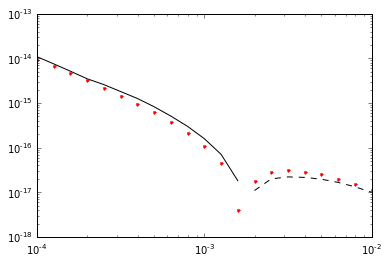

In [27]:
%pylab inline
plt.loglog(rx.times, out, 'k')
plt.loglog(rx.times, -out, 'k--')
plt.loglog(rx.times, bza, 'r.')
plt.loglog(rx.times, -bza, 'r.')

In [30]:
err = np.linalg.norm(bza-out)/np.linalg.norm(bza)
print err

0.147401292841


In [157]:
import numpy as np
from SimPEG.Mesh import CylMesh
from SimPEG.Utils import meshTensor
from EMTD.Utils import hzAnalyticDipoleT_CC
from scipy.constants import mu_0
import matplotlib.pyplot as plt

# flag = "waveform"
flag = "STEPOFF"
## Setup up models
times = [np.r_[1e-5, 1e-4, 1e-3], 
         np.r_[20, 20,  10]]       
em = EMTD_bConv_waveform()
em.mesh = mesh
em.sigmaInf = siginf
em.eta = eta
em.tau = tau
em.c = np.ones_like(eta)*0.7
em.txLoc = np.array([[0., 0., 0.]])
em.rxLoc = np.array([[0., 0., 0.]])
em.RxType = 'Fz'
em.setTimes(times[0], times[1])
em.waveform = "STEPOFF"
em.sourceType = "hLoop"
em.loopRadius = 13.

In [158]:
em.runMUMPS()

>>Initial fields: use STEPOFF
Factoring 1 of 3...
Factor time:  0.0154509544373
Done @ 2016-02-03 22:58:17.997055
>> Initialize e
Factoring 2 of 3...
Factor time:  0.00993585586548
Done @ 2016-02-03 22:58:22.896852
Factoring 3 of 3...
Factor time:  0.00957989692688
Done @ 2016-02-03 22:58:29.864484
FactorTime 0.0349667072296
RhsTime 9.33849406242
SolveTime 0.0867998600006
UpdateTime 5.40082263947
TimeAll 15.7640578747


Populating the interactive namespace from numpy and matplotlib


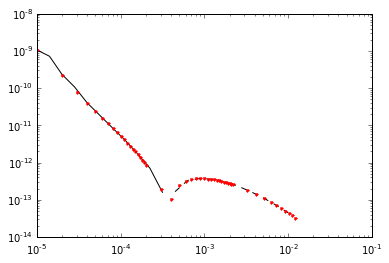

In [167]:
%pylab inline
plt.loglog(rx.times, out, 'k')
plt.loglog(rx.times, -out, 'k--')
plt.loglog(em.tCalc, em.data, 'r.')
plt.loglog(em.tCalc, -em.data, 'r.')